In [2]:
from util import *
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import cross_validate, LeaveOneGroupOut, cross_val_score
from sklearn.svm import LinearSVC, SVC
from sklearn.dummy import DummyClassifier
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stat
from sklearn.decomposition import PCA

/home/vm01/anaconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [3]:
subject_id = '01'
fmri_image = list()
mask_image = list()
for run in range(1, 11):
    if run%2 == 0:
        task = 'rotate'
    else:
        task = 'straight'
    fmri_file = f"data/derivatives/sub-{subject_id}/func/sub-{subject_id}_task-{task}_run-{run}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
    fmri_image.append(fmri_file)


In [3]:
def extract_prep_events_and_indices(events):
    #extracting prep events
    prep_events = events[events['trial_type'].str.contains('prep')].reset_index().drop('index', 1)

    #Renaming conditions column
    prep_events['target_location'] = '207'
    prep_events.loc[prep_events['trial_type'].str.contains('45'), 'target_location'] = '45'
    prep_events.loc[prep_events['trial_type'].str.contains('99'), 'target_location'] = '99'
    prep_events.loc[prep_events['trial_type'].str.contains('153'), 'target_location'] = '153'
    prep_events = prep_events.drop('trial_type', 1)
    prep_events = prep_events.sort_values(by='onset')
    indices = np.floor(prep_events['onset']/1.25).astype(int).values + 3

    return prep_events, indices

In [4]:
def extract_prep_images(indices, fmri_run_image):    
    #Extracting functionl images that correspond to prep times
    prep_images = image.index_img(fmri_run_image, np.ravel(np.vstack((indices, indices+1)), order = 'F'))
    return prep_images


In [4]:
atlas = datasets.fetch_atlas_juelich("maxprob-thr25-2mm")

In [5]:
masks = {"premotor":"GM Premotor cortex BA6", 
         "motor": "GM Primary motor cortex BA4a",
         "v1": "GM Visual cortex V1 BA17",
         "sup_parietal": "GM Superior parietal lobule 7P",
         "inf_parietal": "GM Inferior parietal lobule PF",
         "somatosensory": "GM Primary somatosensory cortex BA1"
        }


In [8]:
#atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')

In [9]:
#atlas.labels

## Voxel Correlations within and across dimensions 

In [7]:
correlations = pd.DataFrame({'runs': np.repeat(np.arange(1, 11), len(masks)),
                           'block_type': np.tile(np.repeat(['Straight', 'Rotate'], len(masks)), 5),
                           'ROIs': np.tile(list(masks.keys()), 10),
                            '45_45': np.zeros(len(masks)*10),
                            '45_99': np.zeros(len(masks)*10),
                            '45_153': np.zeros(len(masks)*10),
                            '45_207': np.zeros(len(masks)*10),

                            '99_45': np.zeros(len(masks)*10),
                            '99_99': np.zeros(len(masks)*10),
                            '99_153': np.zeros(len(masks)*10),
                            '99_207': np.zeros(len(masks)*10),

                            '153_45': np.zeros(len(masks)*10),
                            '153_99': np.zeros(len(masks)*10),
                            '153_153': np.zeros(len(masks)*10),
                            '153_207': np.zeros(len(masks)*10),

                            '207_45': np.zeros(len(masks)*10),
                            '207_99': np.zeros(len(masks)*10),
                            '207_153': np.zeros(len(masks)*10),
                            '207_207': np.zeros(len(masks)*10),
                          })

In [8]:
subject_id = '01'
for run in range(1, 11):
    run_no = str(run).zfill(2)
    beta_maps_dir = f'analyses_results/sub-{subject_id}/beta_maps/trial_level/run-{run_no}/'
    run_beta_maps = os.listdir(f'analyses_results/sub-{subject_id}/beta_maps/trial_level/run-{run_no}/')

    z_maps = {}

    for i in run_beta_maps:
        z_maps[i[5:-7]] = image.load_img(os.path.join(beta_maps_dir, i))

    #Sorted by first number
    all_images = image.concat_imgs((z_maps['153'], z_maps['207'], z_maps['45'], z_maps['99']))
    mean_image = image.mean_img(all_images)
    mean_centered = image.math_img("np.subtract(all_images, mean_image[:, :, :, None])", all_images = all_images, mean_image = mean_image)
    
    for i, key in enumerate(np.sort(list(z_maps.keys()))):
        
        z_maps[key] = image.index_img(mean_centered, slice(i*10,i*10+10))
        
        #For single beta map for odd vs even
        #z_maps[key] = image.index_img(mean_centered, slice(i*2,i*2+2))

    for mask in masks.keys():
        even_dir_dict = {}
        odd_dir_dict = {}
        dir_dict = {}
        
        for direction in z_maps.keys():

            mask_image = image.new_img_like(atlas.maps, image.get_data(atlas.maps) == np.where(np.array(atlas.labels) == masks[mask])[0][0])
            resampled_mask = image.resample_to_img(mask_image, z_maps[direction], interpolation='nearest')

            fmri_masked = masking.apply_mask(z_maps[direction], mask_img=resampled_mask)
            

            even = fmri_masked[0::2]
            odd = fmri_masked[1::2]
            
            #even_centered = even - np.mean(even, axis=0)
            #odd_centered = odd - np.mean(odd, axis = 0)
            
            
            even_dir_dict[direction] = np.mean(even, axis = 0)
            odd_dir_dict[direction] = np.mean(odd, axis = 0)
            dir_dict[direction] = np.mean(fmri_masked, axis = 0)
    
        for c in correlations.columns[3:]:
            even, odd = c.split('_')
            #print(stat.pearsonr(dir_dict_straight[straight], dir_dict_rotate[rotate])[0])
            correlations.loc[((correlations['runs'] == run) & (correlations['ROIs'] == mask) ), c] = stat.pearsonr(even_dir_dict[even], odd_dir_dict[odd])[0] 
    print('Run Done: ', run)
    print(correlations)

Run Done:  1
    runs block_type           ROIs     45_45     45_99    45_153    45_207  \
0      1   Straight       premotor  0.166870 -0.178623 -0.178621 -0.236313   
1      1   Straight          motor  0.182293 -0.142256 -0.196339 -0.213843   
2      1   Straight             v1  0.155132 -0.083988  0.063705 -0.230707   
3      1   Straight   sup_parietal  0.248142 -0.096283 -0.063663 -0.330420   
4      1   Straight   inf_parietal  0.323281 -0.231818 -0.150226 -0.326552   
5      1   Straight  somatosensory  0.098921 -0.205382 -0.118445 -0.094345   
6      2     Rotate       premotor  0.000000  0.000000  0.000000  0.000000   
7      2     Rotate          motor  0.000000  0.000000  0.000000  0.000000   
8      2     Rotate             v1  0.000000  0.000000  0.000000  0.000000   
9      2     Rotate   sup_parietal  0.000000  0.000000  0.000000  0.000000   
10     2     Rotate   inf_parietal  0.000000  0.000000  0.000000  0.000000   
11     2     Rotate  somatosensory  0.000000  0.000

Run Done:  2
    runs block_type           ROIs     45_45     45_99    45_153    45_207  \
0      1   Straight       premotor  0.166870 -0.178623 -0.178621 -0.236313   
1      1   Straight          motor  0.182293 -0.142256 -0.196339 -0.213843   
2      1   Straight             v1  0.155132 -0.083988  0.063705 -0.230707   
3      1   Straight   sup_parietal  0.248142 -0.096283 -0.063663 -0.330420   
4      1   Straight   inf_parietal  0.323281 -0.231818 -0.150226 -0.326552   
5      1   Straight  somatosensory  0.098921 -0.205382 -0.118445 -0.094345   
6      2     Rotate       premotor  0.474853 -0.332735 -0.071502 -0.236754   
7      2     Rotate          motor  0.395759 -0.434543  0.023328 -0.229248   
8      2     Rotate             v1  0.583632 -0.500047 -0.217555 -0.217108   
9      2     Rotate   sup_parietal  0.564030 -0.535670 -0.072178 -0.219168   
10     2     Rotate   inf_parietal  0.397872 -0.448869 -0.043642 -0.164474   
11     2     Rotate  somatosensory  0.539282 -0.590

Run Done:  3
    runs block_type           ROIs     45_45     45_99    45_153    45_207  \
0      1   Straight       premotor  0.166870 -0.178623 -0.178621 -0.236313   
1      1   Straight          motor  0.182293 -0.142256 -0.196339 -0.213843   
2      1   Straight             v1  0.155132 -0.083988  0.063705 -0.230707   
3      1   Straight   sup_parietal  0.248142 -0.096283 -0.063663 -0.330420   
4      1   Straight   inf_parietal  0.323281 -0.231818 -0.150226 -0.326552   
5      1   Straight  somatosensory  0.098921 -0.205382 -0.118445 -0.094345   
6      2     Rotate       premotor  0.474853 -0.332735 -0.071502 -0.236754   
7      2     Rotate          motor  0.395759 -0.434543  0.023328 -0.229248   
8      2     Rotate             v1  0.583632 -0.500047 -0.217555 -0.217108   
9      2     Rotate   sup_parietal  0.564030 -0.535670 -0.072178 -0.219168   
10     2     Rotate   inf_parietal  0.397872 -0.448869 -0.043642 -0.164474   
11     2     Rotate  somatosensory  0.539282 -0.590

Run Done:  4
    runs block_type           ROIs     45_45     45_99    45_153    45_207  \
0      1   Straight       premotor  0.166870 -0.178623 -0.178621 -0.236313   
1      1   Straight          motor  0.182293 -0.142256 -0.196339 -0.213843   
2      1   Straight             v1  0.155132 -0.083988  0.063705 -0.230707   
3      1   Straight   sup_parietal  0.248142 -0.096283 -0.063663 -0.330420   
4      1   Straight   inf_parietal  0.323281 -0.231818 -0.150226 -0.326552   
5      1   Straight  somatosensory  0.098921 -0.205382 -0.118445 -0.094345   
6      2     Rotate       premotor  0.474853 -0.332735 -0.071502 -0.236754   
7      2     Rotate          motor  0.395759 -0.434543  0.023328 -0.229248   
8      2     Rotate             v1  0.583632 -0.500047 -0.217555 -0.217108   
9      2     Rotate   sup_parietal  0.564030 -0.535670 -0.072178 -0.219168   
10     2     Rotate   inf_parietal  0.397872 -0.448869 -0.043642 -0.164474   
11     2     Rotate  somatosensory  0.539282 -0.590

Run Done:  5
    runs block_type           ROIs     45_45     45_99    45_153    45_207  \
0      1   Straight       premotor  0.166870 -0.178623 -0.178621 -0.236313   
1      1   Straight          motor  0.182293 -0.142256 -0.196339 -0.213843   
2      1   Straight             v1  0.155132 -0.083988  0.063705 -0.230707   
3      1   Straight   sup_parietal  0.248142 -0.096283 -0.063663 -0.330420   
4      1   Straight   inf_parietal  0.323281 -0.231818 -0.150226 -0.326552   
5      1   Straight  somatosensory  0.098921 -0.205382 -0.118445 -0.094345   
6      2     Rotate       premotor  0.474853 -0.332735 -0.071502 -0.236754   
7      2     Rotate          motor  0.395759 -0.434543  0.023328 -0.229248   
8      2     Rotate             v1  0.583632 -0.500047 -0.217555 -0.217108   
9      2     Rotate   sup_parietal  0.564030 -0.535670 -0.072178 -0.219168   
10     2     Rotate   inf_parietal  0.397872 -0.448869 -0.043642 -0.164474   
11     2     Rotate  somatosensory  0.539282 -0.590

Run Done:  6
    runs block_type           ROIs     45_45     45_99    45_153    45_207  \
0      1   Straight       premotor  0.166870 -0.178623 -0.178621 -0.236313   
1      1   Straight          motor  0.182293 -0.142256 -0.196339 -0.213843   
2      1   Straight             v1  0.155132 -0.083988  0.063705 -0.230707   
3      1   Straight   sup_parietal  0.248142 -0.096283 -0.063663 -0.330420   
4      1   Straight   inf_parietal  0.323281 -0.231818 -0.150226 -0.326552   
5      1   Straight  somatosensory  0.098921 -0.205382 -0.118445 -0.094345   
6      2     Rotate       premotor  0.474853 -0.332735 -0.071502 -0.236754   
7      2     Rotate          motor  0.395759 -0.434543  0.023328 -0.229248   
8      2     Rotate             v1  0.583632 -0.500047 -0.217555 -0.217108   
9      2     Rotate   sup_parietal  0.564030 -0.535670 -0.072178 -0.219168   
10     2     Rotate   inf_parietal  0.397872 -0.448869 -0.043642 -0.164474   
11     2     Rotate  somatosensory  0.539282 -0.590

Run Done:  7
    runs block_type           ROIs     45_45     45_99    45_153    45_207  \
0      1   Straight       premotor  0.166870 -0.178623 -0.178621 -0.236313   
1      1   Straight          motor  0.182293 -0.142256 -0.196339 -0.213843   
2      1   Straight             v1  0.155132 -0.083988  0.063705 -0.230707   
3      1   Straight   sup_parietal  0.248142 -0.096283 -0.063663 -0.330420   
4      1   Straight   inf_parietal  0.323281 -0.231818 -0.150226 -0.326552   
5      1   Straight  somatosensory  0.098921 -0.205382 -0.118445 -0.094345   
6      2     Rotate       premotor  0.474853 -0.332735 -0.071502 -0.236754   
7      2     Rotate          motor  0.395759 -0.434543  0.023328 -0.229248   
8      2     Rotate             v1  0.583632 -0.500047 -0.217555 -0.217108   
9      2     Rotate   sup_parietal  0.564030 -0.535670 -0.072178 -0.219168   
10     2     Rotate   inf_parietal  0.397872 -0.448869 -0.043642 -0.164474   
11     2     Rotate  somatosensory  0.539282 -0.590

Run Done:  8
    runs block_type           ROIs     45_45     45_99    45_153    45_207  \
0      1   Straight       premotor  0.166870 -0.178623 -0.178621 -0.236313   
1      1   Straight          motor  0.182293 -0.142256 -0.196339 -0.213843   
2      1   Straight             v1  0.155132 -0.083988  0.063705 -0.230707   
3      1   Straight   sup_parietal  0.248142 -0.096283 -0.063663 -0.330420   
4      1   Straight   inf_parietal  0.323281 -0.231818 -0.150226 -0.326552   
5      1   Straight  somatosensory  0.098921 -0.205382 -0.118445 -0.094345   
6      2     Rotate       premotor  0.474853 -0.332735 -0.071502 -0.236754   
7      2     Rotate          motor  0.395759 -0.434543  0.023328 -0.229248   
8      2     Rotate             v1  0.583632 -0.500047 -0.217555 -0.217108   
9      2     Rotate   sup_parietal  0.564030 -0.535670 -0.072178 -0.219168   
10     2     Rotate   inf_parietal  0.397872 -0.448869 -0.043642 -0.164474   
11     2     Rotate  somatosensory  0.539282 -0.590

Run Done:  9
    runs block_type           ROIs     45_45     45_99    45_153    45_207  \
0      1   Straight       premotor  0.166870 -0.178623 -0.178621 -0.236313   
1      1   Straight          motor  0.182293 -0.142256 -0.196339 -0.213843   
2      1   Straight             v1  0.155132 -0.083988  0.063705 -0.230707   
3      1   Straight   sup_parietal  0.248142 -0.096283 -0.063663 -0.330420   
4      1   Straight   inf_parietal  0.323281 -0.231818 -0.150226 -0.326552   
5      1   Straight  somatosensory  0.098921 -0.205382 -0.118445 -0.094345   
6      2     Rotate       premotor  0.474853 -0.332735 -0.071502 -0.236754   
7      2     Rotate          motor  0.395759 -0.434543  0.023328 -0.229248   
8      2     Rotate             v1  0.583632 -0.500047 -0.217555 -0.217108   
9      2     Rotate   sup_parietal  0.564030 -0.535670 -0.072178 -0.219168   
10     2     Rotate   inf_parietal  0.397872 -0.448869 -0.043642 -0.164474   
11     2     Rotate  somatosensory  0.539282 -0.590

Run Done:  10
    runs block_type           ROIs     45_45     45_99    45_153    45_207  \
0      1   Straight       premotor  0.166870 -0.178623 -0.178621 -0.236313   
1      1   Straight          motor  0.182293 -0.142256 -0.196339 -0.213843   
2      1   Straight             v1  0.155132 -0.083988  0.063705 -0.230707   
3      1   Straight   sup_parietal  0.248142 -0.096283 -0.063663 -0.330420   
4      1   Straight   inf_parietal  0.323281 -0.231818 -0.150226 -0.326552   
5      1   Straight  somatosensory  0.098921 -0.205382 -0.118445 -0.094345   
6      2     Rotate       premotor  0.474853 -0.332735 -0.071502 -0.236754   
7      2     Rotate          motor  0.395759 -0.434543  0.023328 -0.229248   
8      2     Rotate             v1  0.583632 -0.500047 -0.217555 -0.217108   
9      2     Rotate   sup_parietal  0.564030 -0.535670 -0.072178 -0.219168   
10     2     Rotate   inf_parietal  0.397872 -0.448869 -0.043642 -0.164474   
11     2     Rotate  somatosensory  0.539282 -0.59

In [24]:
bw_correlations = pd.DataFrame({'run_pairs': np.tile(np.arange(1, 6), len(masks)),
                           #'block_type': np.tile(np.repeat(['Straight', 'Rotate'], 8), 5),
                                'ROIs': np.repeat(list(masks.keys()), 5),
                                '45_45': np.zeros(len(masks)*5),
                                '45_99': np.zeros(len(masks)*5),
                                '45_153': np.zeros(len(masks)*5),
                                '45_207': np.zeros(len(masks)*5),
                                                               
                                '99_45': np.zeros(len(masks)*5),
                                '99_99': np.zeros(len(masks)*5),
                                '99_153': np.zeros(len(masks)*5),
                                '99_207': np.zeros(len(masks)*5),

                                '153_45': np.zeros(len(masks)*5),
                                '153_99': np.zeros(len(masks)*5),
                                '153_153': np.zeros(len(masks)*5),
                                '153_207': np.zeros(len(masks)*5),

                                '207_45': np.zeros(len(masks)*5),
                                '207_99': np.zeros(len(masks)*5),
                                '207_153': np.zeros(len(masks)*5),
                                '207_207': np.zeros(len(masks)*5),
                               
                               })

In [25]:
subject_id = '02'
for mask in masks.keys():
    mask_image = image.new_img_like(atlas.maps, image.get_data(atlas.maps) == np.where(np.array(atlas.labels) == masks[mask])[0][0])

    for run in range(1, 11):
        run_no = str(run).zfill(2)
        beta_maps_dir = f'analyses_results/sub-{subject_id}/beta_maps/direction_level/run-{run_no}/'
        run_beta_maps = os.listdir(f'analyses_results/sub-{subject_id}/beta_maps/direction_level/run-{run_no}/')
        
        z_maps = {}
        
        for i in run_beta_maps:
            z_maps[i[5:-7]] = image.load_img(os.path.join(beta_maps_dir, i))

        
        all_images = image.concat_imgs((z_maps['153'], z_maps['207'], z_maps['45'],z_maps['99']))
        mean_image = image.mean_img(all_images)
        mean_centered = image.math_img("np.subtract(all_images, mean_image[:, :, :, None])", all_images = all_images, mean_image = mean_image)

        for i, key in enumerate(np.sort(list(z_maps.keys()))):
            #z_maps[key] = image.index_img(mean_centered, slice(i*10,i*10+10))
            #z_maps[key] = image.index_img(mean_centered, slice(i*2,i*2+2))
            z_maps[key] = image.index_img(mean_centered, slice(i*1,i*1+1))


        if run%2 != 0:
            dir_dict_straight = {}
            for direction in z_maps.keys():

                resampled_mask = image.resample_to_img(mask_image, z_maps[direction], interpolation='nearest')

                fmri_masked = masking.apply_mask(z_maps[direction], mask_img=resampled_mask)
                dir_dict_straight[direction] = np.mean(fmri_masked, axis = 0)
                
        else:
            
            dir_dict_rotate = {}
            for direction in z_maps.keys():
                resampled_mask = image.resample_to_img(mask_image, z_maps[direction], interpolation='nearest')
                #nifti_masker = NiftiMasker(mask_img=resampled_mask, standardize=True)

                fmri_masked = masking.apply_mask(z_maps[direction], mask_img=resampled_mask)
                dir_dict_rotate[direction] = np.mean(fmri_masked, axis = 0)
                
            for c in bw_correlations.columns[2:]:
                straight, rotate = c.split('_')
                #print(stat.pearsonr(dir_dict_straight[straight], dir_dict_rotate[rotate])[0])
                bw_correlations.loc[((bw_correlations['run_pairs'] == int(run/2)) & (bw_correlations['ROIs'] == mask) ), c] = stat.pearsonr(dir_dict_straight[straight], dir_dict_rotate[rotate])[0]

        

    print('Run Done: ', run)
    print(bw_correlations)

Run Done:  10
    run_pairs           ROIs     45_45     45_99    45_153    45_207  \
0           1       premotor  0.023990 -0.022760  0.035137 -0.047052   
1           2       premotor  0.171015  0.002922 -0.186679 -0.000905   
2           3       premotor  0.176068 -0.136020  0.000998 -0.075140   
3           4       premotor -0.060653 -0.200028  0.199962  0.087626   
4           5       premotor  0.051126 -0.054198  0.029154 -0.018007   
5           1          motor  0.000000  0.000000  0.000000  0.000000   
6           2          motor  0.000000  0.000000  0.000000  0.000000   
7           3          motor  0.000000  0.000000  0.000000  0.000000   
8           4          motor  0.000000  0.000000  0.000000  0.000000   
9           5          motor  0.000000  0.000000  0.000000  0.000000   
10          1             v1  0.000000  0.000000  0.000000  0.000000   
11          2             v1  0.000000  0.000000  0.000000  0.000000   
12          3             v1  0.000000  0.000000  

Run Done:  10
    run_pairs           ROIs     45_45     45_99    45_153    45_207  \
0           1       premotor  0.023990 -0.022760  0.035137 -0.047052   
1           2       premotor  0.171015  0.002922 -0.186679 -0.000905   
2           3       premotor  0.176068 -0.136020  0.000998 -0.075140   
3           4       premotor -0.060653 -0.200028  0.199962  0.087626   
4           5       premotor  0.051126 -0.054198  0.029154 -0.018007   
5           1          motor  0.069760  0.063723 -0.076773 -0.071618   
6           2          motor  0.190106 -0.052279 -0.146200 -0.005812   
7           3          motor  0.179646 -0.192125  0.014060 -0.022392   
8           4          motor -0.019825 -0.279218  0.172857  0.180824   
9           5          motor  0.076991 -0.088035  0.079386 -0.054982   
10          1             v1  0.058042  0.090946 -0.073891 -0.100658   
11          2             v1  0.344280 -0.039145 -0.190056 -0.193829   
12          3             v1  0.271398 -0.003330 -

Run Done:  10
    run_pairs           ROIs     45_45     45_99    45_153    45_207  \
0           1       premotor  0.023990 -0.022760  0.035137 -0.047052   
1           2       premotor  0.171015  0.002922 -0.186679 -0.000905   
2           3       premotor  0.176068 -0.136020  0.000998 -0.075140   
3           4       premotor -0.060653 -0.200028  0.199962  0.087626   
4           5       premotor  0.051126 -0.054198  0.029154 -0.018007   
5           1          motor  0.069760  0.063723 -0.076773 -0.071618   
6           2          motor  0.190106 -0.052279 -0.146200 -0.005812   
7           3          motor  0.179646 -0.192125  0.014060 -0.022392   
8           4          motor -0.019825 -0.279218  0.172857  0.180824   
9           5          motor  0.076991 -0.088035  0.079386 -0.054982   
10          1             v1  0.058042  0.090946 -0.073891 -0.100658   
11          2             v1  0.344280 -0.039145 -0.190056 -0.193829   
12          3             v1  0.271398 -0.003330 -

In [11]:
correlations_melt = correlations.melt(id_vars=['runs', 'block_type', 'ROIs'], var_name = 'correlations', value_name='corr')

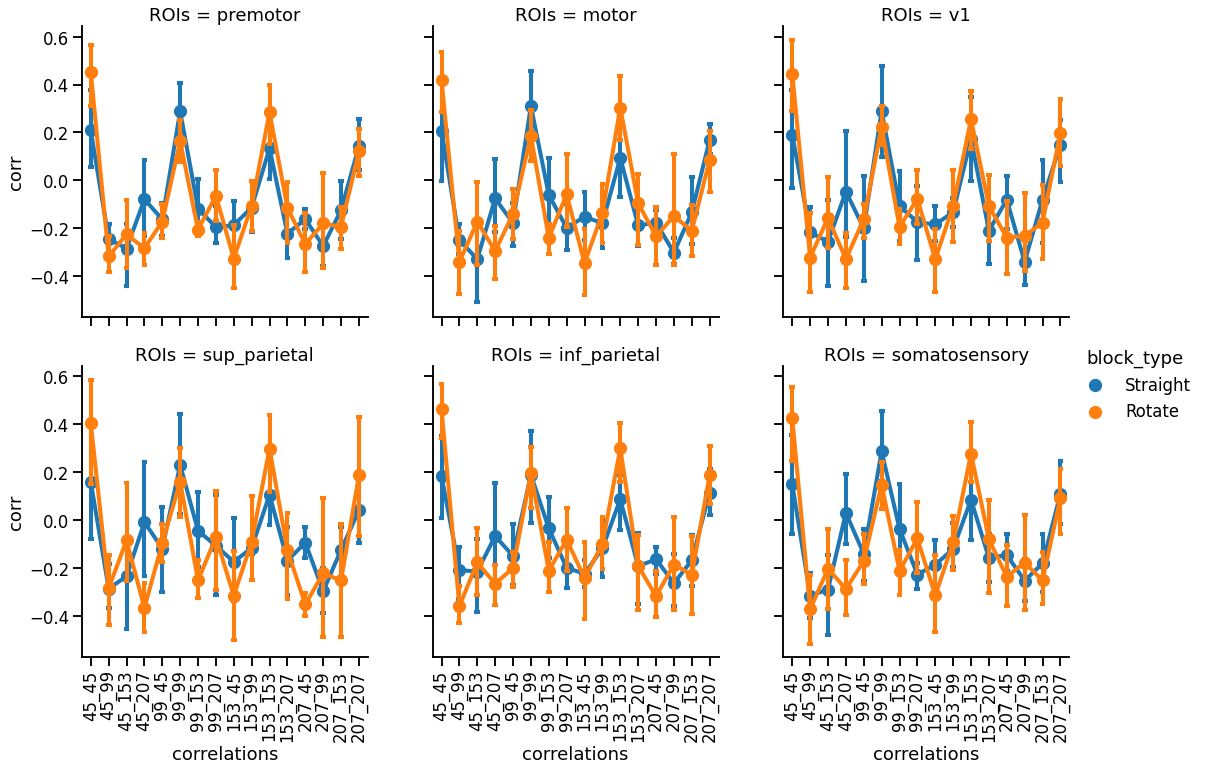

In [12]:
sns.set_context('talk')
g = sns.catplot(x = 'correlations', y = 'corr', hue = 'block_type', col = 'ROIs', col_wrap = 3,
                kind = 'point', data = correlations_melt.loc[correlations_melt['runs'] < 11], capsize = 0.1)

g.set_axis_labels().set_xticklabels(rotation = 90)

In [26]:
bw_correlations_melt = bw_correlations.melt(id_vars=['run_pairs',  'ROIs'], var_name = 'correlations', value_name='corr')

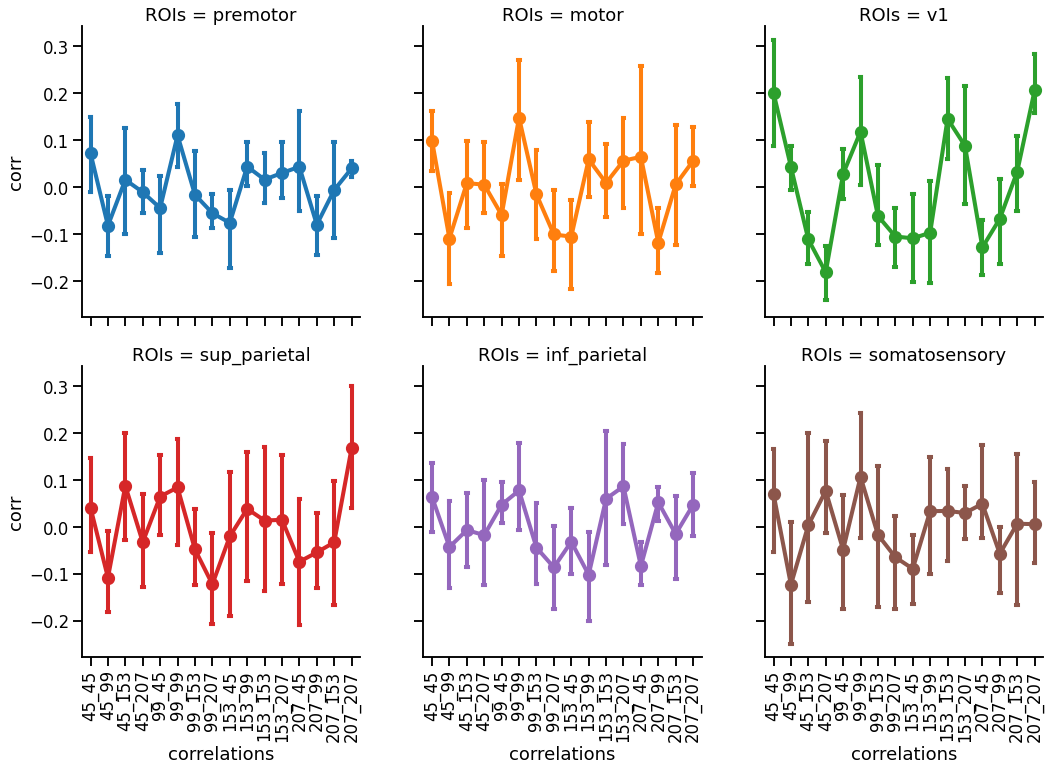

In [27]:
sns.set_context('talk')

ax = sns.catplot(x = 'correlations', y = 'corr', hue = 'ROIs', col = 'ROIs', col_wrap=3,
                 kind = 'point', data = bw_correlations_melt.loc[((bw_correlations_melt['run_pairs'] <= 10))], capsize = 0.1)

ax.set_axis_labels().set_xticklabels(rotation = 90)

In [28]:
aim = []
for i in bw_correlations_melt.correlations.str.split('_').values:
    aim.append((int(i[0]) - (int(i[1]) - 90)))

In [29]:
bw_correlations_melt['aim_diff'] = aim

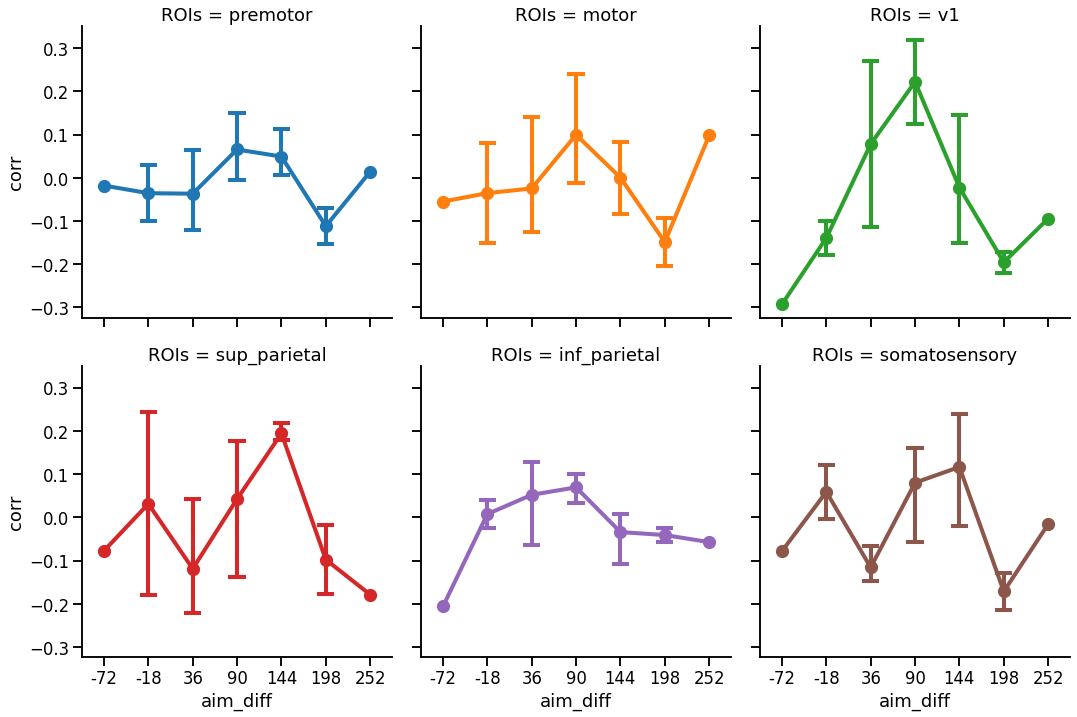

In [33]:
sns.catplot(x = "aim_diff", y = "corr", hue = 'ROIs', col = 'ROIs', col_wrap = 3,
            order = np.sort(np.unique(bw_correlations_melt['aim_diff'])),
            data = bw_correlations_melt.loc[((bw_correlations_melt['run_pairs'] == 5))], kind = 'point', capsize = 0.3)